<h1>
Feature analysis and initial modelling
</h1>

After finalizing the data, basic EDA is performed on it. Loading the final data is done, to perform EDA.

In [1]:
#Importing Libraries
import pandas as pd
import re
from textblob import TextBlob
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import euclidean_distances
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
# Loading the final data
data=pd.read_csv('final_data.csv')
# Displaying rows and columns of the data
print(data.shape)
# Displaying the first row of the data.
data.head(1)

(100000, 22)


,review_id,user_id,business_id,review_stars,useful,funny,cool,text,date,name,address,city,state,postal_code,latitude,longitude,business_stars,review_count,is_open,attributes,categories,hours
0,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52,Rio Hair Salon,2990 N Alma School Rd,Chandler,AZ,85224,33.348382,-111.859189,1.5,3.0,1.0,NaN,"Beauty & Spas, Hair Salons",NaN


In [3]:
# Returning the length of review id, text, star rating
reviews=data[['review_id','text','review_stars']]
def total_len(x):
  return len(str(x).split())

# Finding the length of stop words
def stop_len(x):
  stop=set(stopwords.words('english'))
  stop_words=' '.join([i for i in str(x).lower().split() if i not in stop])
  return len(stop_words.split())

# Returning the length of new special string
def special_len(x):
  new=re.sub('[\w]+','',str(x))
  if len(new)>0:
    return len(new)
  else:
    return 0

# Returning the pos tag length
def pos_tags(x):
  specialChar=re.sub(r"[^a-zA-Z]+",'',str(x))
  stop=set(stopwords.words('english'))
  stop_words=' '.join([i for i in specialChar.lower().split() if i in stop])
  mapping=pos_tag(word_tokenize(stop_words))
  tags=([i[1] for i in mapping])
  return dict(Counter(tags))

  
def lemma_len(x):
  specialChar=re.sub(r"[^a-zA-Z]+",' ',str(x))
  stop=set(stopwords.words('english'))
  stop_words=' '.join([i for i in specialChar.lower().split() if i in stop])
  wnl=WordNetLemmatizer()
  para=[]
  for word,tag in pos_tag(word_tokenize(stop_words)):
    wntag=tag[0].lower()
    wntag=wntag if wntag in ['a','r','n','v'] else None
    if not wntag:
      lemma=word
    else:
      lemma=wnl.lemmatize(word,wntag)
    if lemma in stop_words.split():
      pass
    else:
      para.append(lemma)

  return len(para)

# Loading the pos list into an array.
def pos_list(df,col):
  final=[]
  for i in range(0, df[col].shape[0]):
    for x in list(df[col][i].keys()):
      if x not in final:
        final.append(x)

  for i in final:
    def dummy(x):
      if i in list(x.keys()):
        return x[i]
      else:
        return 0
    df[i]=df['pos_lis'].apply(dummy)

  return df

# Cleaning the data by removing the quotations, empty spaces, empty strings, removing urls, special characters
def cleansing(x):
  x=str(x)
  quoteRemoval=x.replace('"','')
  spaceRemoval=re.sub("\s\s+"," ",quoteRemoval)
  stringRemoval=spaceRemoval.strip()
  urlRemove=re.sub(r'http\S+','',stringRemoval)
  specialChar=re.sub(r"[^a-zA-Z]+",' ',urlRemove)
  return specialChar

# Calculating the polarity
def get_polarity(x):
  try:
    blob=TextBlob(x)
    pol=blob.sentiment.polarity
  except:
    pol=0.0

  return pol

# Calculating the subjectivity    
def get_subjectivity(x):
  try:
    blob=TextBlob(x)
    subj=blob.sentiment.subjectivity
  except:
    subj=0.0

  return subj

In [4]:
#Applying the above functions to perform feature analysis and inital eda
reviews['clean_text']=reviews['text'].apply(cleansing)
reviews['total_len']=reviews['clean_text'].apply(total_len)
reviews['stop_len']=reviews['clean_text'].apply(stop_len)
reviews['special_len']=reviews['clean_text'].apply(special_len)
reviews['lemma_len']=reviews['clean_text'].apply(lemma_len)
reviews['polarity']=reviews['clean_text'].apply(get_polarity)
reviews['subjectivity']=reviews['clean_text'].apply(get_subjectivity)

reviews['word_count']=reviews['clean_text'].apply(lambda x : len(str(x).split()))
reviews['word_density']=reviews['total_len']/(reviews['word_count']+1)
reviews['unique_words']=reviews['clean_text'].apply(lambda x : len(set(str(x).split())))
reviews['mean_word_len']=reviews['clean_text'].apply(lambda x : np.mean([len(i) for i in str(x).split()]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [5]:
# Converting the features into final_feature
reviews.to_csv('final_full_feature_reviews.csv', index=False)

**EDA**

In [20]:
# Displaying the top 10 cities with most reviews.
n=10
df2=data['city'].value_counts().nlargest(n)
df2

Las Vegas     29770
Phoenix       10241
Toronto        7370
Scottsdale     5531
Charlotte      5467
Pittsburgh     3892
Henderson      3534
Tempe          2926
Montr√©al      2600
Mesa           2391
Name: city, dtype: int64

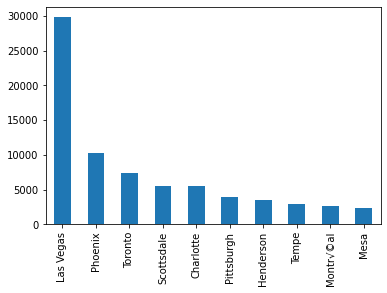

In [21]:
# Plotting the graph for top 10 cities with most reviews
df2.plot(kind='bar')

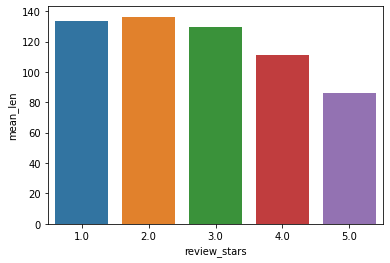

In [6]:
# Finding the mean length of the reviews based on star rating.
import seaborn as sns
temp=reviews.groupby('review_stars')['total_len'].agg('mean').reset_index()
temp.columns=['review_stars','mean_len']
sns.barplot(x='review_stars', y='mean_len', data=temp)

In [7]:
print(temp)

   review_stars    mean_len
0           1.0  133.798646
1           2.0  136.262553
2           3.0  129.591824
3           4.0  111.357334
4           5.0   86.028511


**Best Review has less mean length**

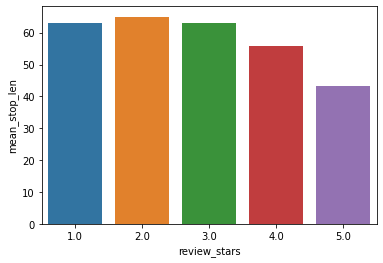

In [8]:
# Finding the length of stop words based on star rating
temp=reviews.groupby('review_stars')['stop_len'].agg('mean').reset_index()
temp.columns=['review_stars','mean_stop_len']
sns.barplot(x='review_stars', y='mean_stop_len', data=temp)

In [9]:
print(temp)

   review_stars  mean_stop_len
0           1.0      62.877602
1           2.0      64.962737
2           3.0      63.062439
3           4.0      55.662881
4           5.0      43.216721


**Best review has less stop words**

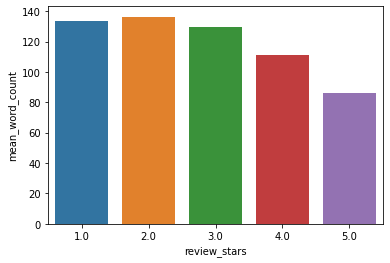

In [10]:
# Finding the average number of words for individual star rating.
temp=reviews.groupby('review_stars')['word_count'].agg('mean').reset_index()
temp.columns=['review_stars','mean_word_count']
sns.barplot(x='review_stars', y='mean_word_count', data=temp)

**Best Review has less words**

<b><h1> LGBM Model: </h1><b>

In [11]:
# Importing libraries
from sklearn.model_selection import train_test_split

In [13]:
# Importing csv file
f=pd.read_csv("final_full_feature_reviews.csv")

# Applying lambda function
f['review_stars']=f['review_stars'].apply(lambda x : int(x-1))
X=f.drop(['review_id','clean_text','text','review_stars'], axis=1)
y=f[['review_stars']]

# Evaluating the X_train, X_test, Y_train, Y_test and assigning test size as 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.2, random_state=42,stratify=y_train)

#Printing size of X_train
print("Train : ", X_train.shape)

#Printing size of X_validation
print("Valid : ", X_val.shape)

#Printing size of X_test
print("Test : ", X_test.shape)
print(y_train.review_stars.value_counts())

Train :  (64000, 10)
Valid :  (16000, 10)
Test :  (20000, 10)
4    28217
3    14595
0     8795
2     7155
1     5238
Name: review_stars, dtype: int64


In [14]:
# Importing lgbm libraries
import lightgbm as lgb
from sklearn.metrics import f1_score
import numpy as np

In [15]:
# Loading X_train, y_train to lgmb_train
lgb_train=lgb.Dataset(X_train,label=list(y_train.review_stars))
lgb_val=lgb.Dataset(X_val,label=list(y_val.review_stars))
# Setting the parameters like multiclass and number of classes as 5 as there are 5 categories for reviews
params={'application':'multiclass',
        'num_class':5,
        'learning_rate':0.01,
        }
model=lgb.train(params,num_boost_round=10000,early_stopping_rounds=1000,verbose_eval=1000,train_set=lgb_train, valid_sets=[lgb_train, lgb_val])

preds=model.predict(X_test[X_train.columns])
y_pred = []

for x in preds:
    y_pred.append(np.argmax(x))

res1=pd.DataFrame()
res1['actual']=list(y_test['review_stars'])
res1['prediction']=y_pred
res1['prediction']=res1['prediction']
print(res1.head())
# Crosstab of actual vs predicted data
print(pd.crosstab(res1.actual, res1.prediction))
# Calculate and print the accuracy, precision, Recall and F1 Score
from sklearn.metrics import *
print("Accuracy is ",accuracy_score(res1.actual, res1.prediction))
print("Precision is ",precision_score(res1.actual, res1.prediction, average='weighted'))
print("Recall is ",recall_score(res1.actual, res1.prediction, average='weighted'))
print("F1-Score is ",f1_score(res1.actual, res1.prediction, average='weighted'))


Training until validation scores don't improve for 1000 rounds.
[1000]	training's multi_logloss: 1.05827	valid_1's multi_logloss: 1.11735
Early stopping, best iteration is:
[944]	training's multi_logloss: 1.06153	valid_1's multi_logloss: 1.1173
   actual  prediction
0       4           4
1       3           4
2       1           0
3       4           4
4       2           0
prediction     0   1   2    3     4
actual                             
0           2066  42  64  146   430
1            758  62  84  222   511
2            461  49  90  404  1232
3            323  36  90  514  3598
4            332  30  57  447  7952
Accuracy is  0.5342
Precision is  0.4444798083823014
Recall is  0.5342
F1-Score is  0.44636358693703404


<h1><b>Cat Boost Classifier</b></h1>

In [16]:
# Import Libraries
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 67.3MB 59kB/s 


In [17]:
# Calucate the learning rate 
cat_model=CatBoostClassifier(loss_function='MultiClass', iterations=10000, learning_rate=0.01,verbose=1000)
# Fit the model to X_train and Y_train
cat_model.fit(X_train, y_train)

0:	learn: 1.5997566	total: 111ms	remaining: 18m 31s
1000:	learn: 1.1134021	total: 56.1s	remaining: 8m 24s
2000:	learn: 1.0968763	total: 1m 51s	remaining: 7m 25s
3000:	learn: 1.0835052	total: 2m 47s	remaining: 6m 29s
4000:	learn: 1.0715893	total: 3m 43s	remaining: 5m 34s
5000:	learn: 1.0605016	total: 4m 39s	remaining: 4m 39s
6000:	learn: 1.0500117	total: 5m 36s	remaining: 3m 44s
7000:	learn: 1.0399378	total: 6m 32s	remaining: 2m 48s
8000:	learn: 1.0303574	total: 7m 29s	remaining: 1m 52s
9000:	learn: 1.0209867	total: 8m 28s	remaining: 56.4s
9999:	learn: 1.0117442	total: 9m 27s	remaining: 0us


In [ ]:
preds=cat_model.predict(X_test[X_train.columns])
res2=pd.DataFrame()
# Set the actual data with y_test of review_stars
res2['actual']=list(y_test['review_stars'])
res2['prediction']=preds
res2['prediction']=res2['prediction']
print(res2.head())
# Crosstab of actual vs predicted data
print(pd.crosstab(res2.actual, res2.prediction))
# Calculate and print the accuracy, precission, recall and F-1 score.
from sklearn.metrics import *
print("Accuracy is ",accuracy_score(res2.actual, res2.prediction)*100)
print("Precision is ",precision_score(res2.actual, res2.prediction, average='weighted'))
print("Recall is ",recall_score(res2.actual, res2.prediction, average='weighted'))
print("F1-Score is ",f1_score(res2.actual, res2.prediction, average='weighted'))



   actual  prediction
0       4           4
1       3           4
2       1           0
3       4           4
4       2           0
prediction     0    1    2    3     4
actual                               
0           2029   81   89  115   434
1            707  103  126  222   479
2            418   69  156  400  1193
3            273   54  146  605  3483
4            311   37  106  531  7833
Accuracy is  53.63
Precision is  0.4580528415000786
Recall is  0.5363
F1-Score is  0.4601377464575189
